# VGG 16 with Active Learning

## Loading the dataset

In [9]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from lib.dataset import Dataset

In [10]:
dataset = Dataset()

Loading local preprocessed dataset...
Finished


In [11]:
X_train, X_test, y_train, y_test = dataset.split()

X_train shape: (3228, 224, 224, 3)
X_test shape: (807, 224, 224, 3)
y_train shape: (3228,)
y_test shape: (807,)


In [12]:
# Run cell to preview data
#dataset.show_unprocessed_examples() # uncomment line

In [13]:
y_train_classlist = np.array(list(map(dataset.to_classlist, y_train)))

In [14]:
y_test_classlist = np.array(list(map(dataset.to_classlist, y_test)))
y_test_labels = np.array(list(map(dataset.to_label, y_test)))

y_test_from_classlist = np.array(list(map(dataset.from_classlist, y_test_classlist)))
y_test_from_labels = np.array(list(map(dataset.from_label, y_test_labels)))

## Training the model with Active Learning

In [15]:
%%capture --no-display
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy


model = VGG16(weights=None, classes=3)
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy']);

2022-11-26 13:30:24.511900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 13:30:27.263364: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-26 13:30:28.513568: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/gent/RHEL8/cascadelake-ib/software/ZeroMQ/4.3.4-GCCcore-11.2.0/lib:/apps/gent

In [16]:
# Fit model on first 100 images
idxs = [i for i in range(128)]
used = np.array(idxs)
model.fit(x=X_train[idxs], y=y_train_classlist[idxs], epochs=10, batch_size=64)
X_train = np.delete(X_train, idxs, axis=0)
y_train_classlist = np.delete(y_train_classlist, idxs, axis=0)
X_pred = model.predict(X_train)

101/101 [==============================] - 673s 7s/step


In [ ]:
# Perform Active learning
iterations = 10
query_size = 128
epochs = 10
batch_size = 64

print(f"Performing {iterations} iterations with {query_size} queried images")

for _ in range(iterations):
    idxs = np.max(X_pred, axis=1).argsort()
    used = np.concatenate((used, idxs[:query_size]))
    model.fit(x=X_train[idxs[:query_size]], y=y_train_classlist[idxs[:query_size]], epochs=epochs, batch_size=batch_size)
    X_train = np.delete(X_train, idxs[:query_size], axis=0)
    y_train_classlist = np.delete(y_train_classlist, idxs[:query_size], axis=0)
    X_pred = model.predict(X_train)

Performing 10 iterations with 128 queried images
Epoch 1/10


In [17]:
# Save model
model.save("models/" + str(datetime.now().isoformat("-", "minutes")) + ".h5")

([<matplotlib.axis.XTick at 0x14a5b3f959a0>,
 [Text(0, 0, 'COVID'), Text(1, 0, 'Normal'), Text(2, 0, 'Viral Pneumonia')])

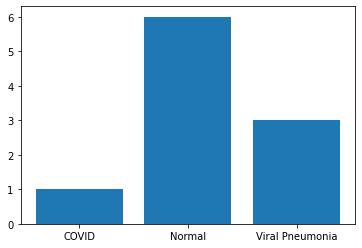

In [19]:
# Show histogram of used classes
y_train_labels = np.array(list(map(dataset.to_label, y_train)))

labels, counts = np.unique(y_train_labels[used], return_counts=True)
ticks = range(len(counts))
plt.bar(ticks, counts, align='center')
plt.xticks(ticks, labels)